# Detection black dot on a white paper

Source: https://github.com/BTifmmp/paper-piano/blob/main/paper-piano/detection.py

This notebook is to test & learn some OpenCV processing skills via trying the repo mentioned above.

To test in colab, remember to upload your own image and change the image path

<a target="_blank" href="https://colab.research.google.com/github/keithleungwork/opencv_sample/blob/main/src/white_paper_black_dot.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint

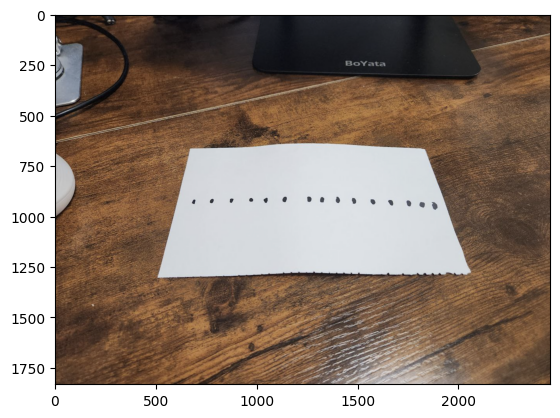

In [18]:
# Load the testing image
path = "tmp/black_dot.png"

# Reading an image in default mode 
src = cv2.imread(path) 

# Prepare some useful helpers
# note: OpenCV uses BGR color order
def show_image(src, is_grey=False):
    if is_grey:
        plt.imshow(src, cmap='gray')
    else:
        # convert to RGB
        rgb_src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_src)

def show_two_images(src1, src2, is_grey=False):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    show_image(src1, is_grey=is_grey)
    plt.title('After')
    plt.subplot(1, 2, 2)
    show_image(src2, is_grey=is_grey)
    plt.title('Before')

def draw_contours(src_img, contours, index=-1, color=(0, 255, 0), thickness=3):
    image_contour = src_img.copy()
    cv2.drawContours(image_contour, contours, index, color, thickness)
    return image_contour

show_image(src)


-------
## Detect the white paper

Instead of jumping into detecting the black dot, we extract the white paper first.

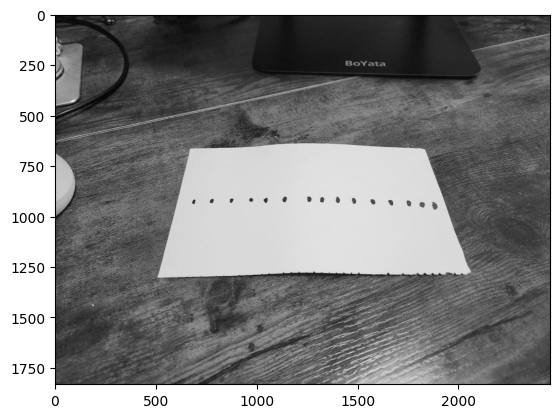

In [6]:
# We will do the canny edge detection and find all contours.
# First we need to convert the image to greyscale and apply some blurring
image_grey = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY ) 

# Displaying the image via matplotlib
show_image(image_grey, is_grey=True)

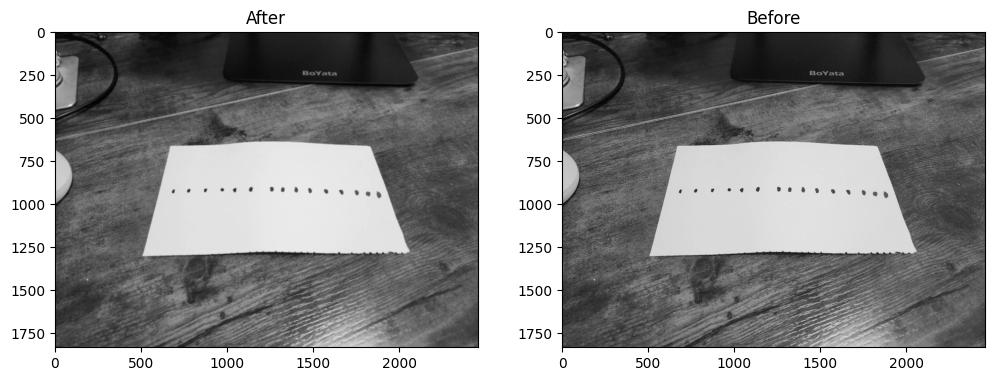

In [7]:
blur=11
blur_img = cv2.GaussianBlur(image_grey, (blur, blur), 0)
# blur_img = cv2.medianBlur(image_grey,5)

show_two_images( blur_img,image_grey, is_grey=True)

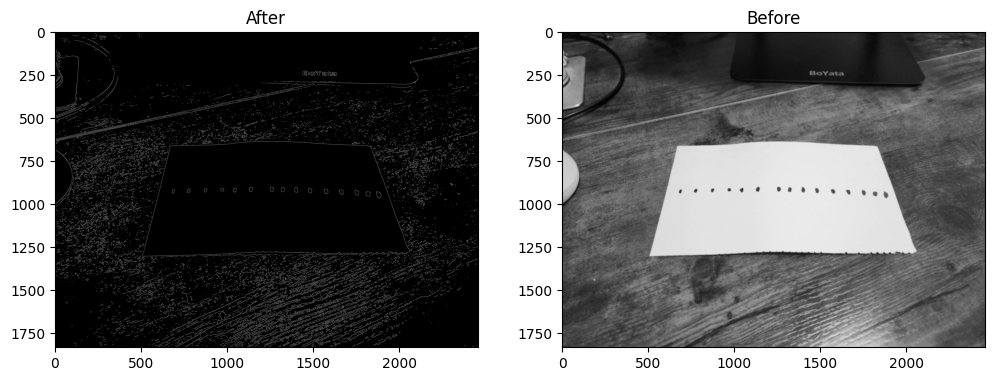

In [8]:
# This will detect the edges in the image
canny_img = cv2.Canny(blur_img, 40, 40, L2gradient=True)

show_two_images( canny_img,blur_img, is_grey=True)

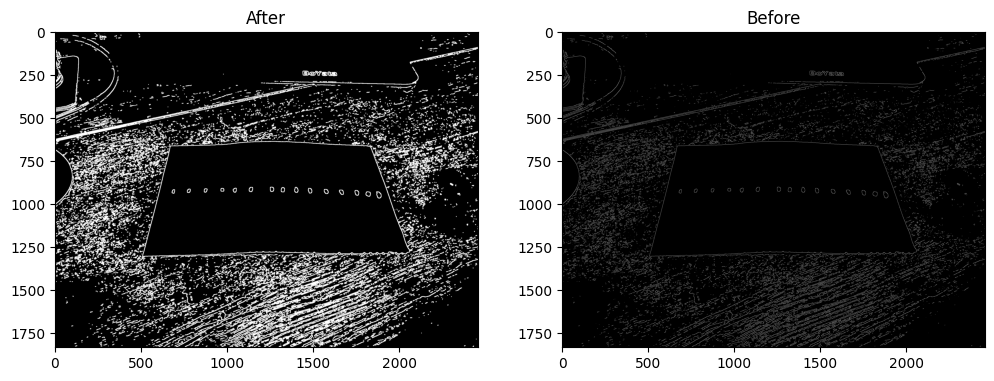

In [9]:
# Apply morphological transformation
kernel = np.ones((4,4),np.uint8)
morph_img = cv2.morphologyEx(canny_img, cv2.MORPH_DILATE, kernel)

show_two_images( morph_img, canny_img, is_grey=True)


In [14]:
contours, _ = cv2.findContours(morph_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# sample
contours[:2]

(array([[[1190, 1829]],
 
        [[1190, 1831]],
 
        [[1193, 1831]],
 
        [[1193, 1829]]], dtype=int32),
 array([[[1510, 1828]],
 
        [[1510, 1831]],
 
        [[1515, 1831]],
 
        [[1515, 1828]]], dtype=int32))

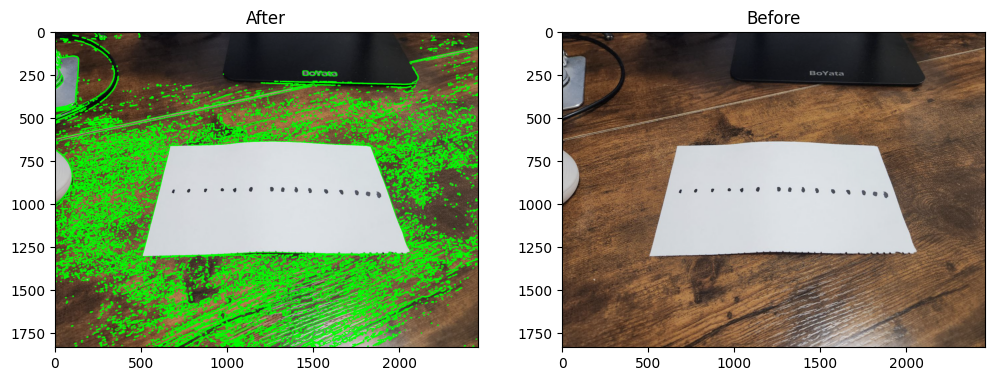

In [19]:
# Draw all contours on the original image
show_two_images(draw_contours(src, contours), src, is_grey=False)

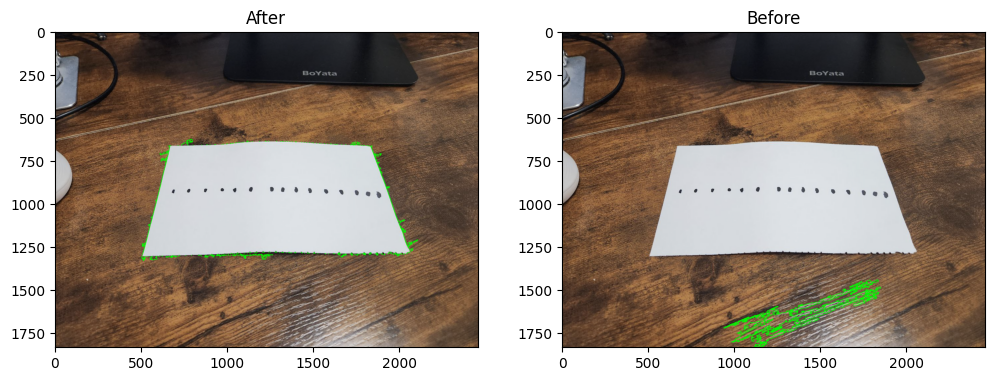

In [20]:

# Find the "largest" contour, assuming the white object is the largest
# Also keep the second largest contour for comparison
cnt = contours[0]
cnt2 = contours[0]
for each_c in contours:
    # find the contour with the most points
    # if len(each_c) > len(cnt):
    #     cnt = each_c

    # find the contour with the largest area
    if cv2.contourArea(each_c) > cv2.contourArea(cnt):
        cnt2 = cnt
        cnt = each_c


# Draw both contours to compare
show_two_images( 
    draw_contours(src, cnt),
    draw_contours(src, cnt2),
    is_grey=False)


How many vertices:  6
isContourConvex:  False


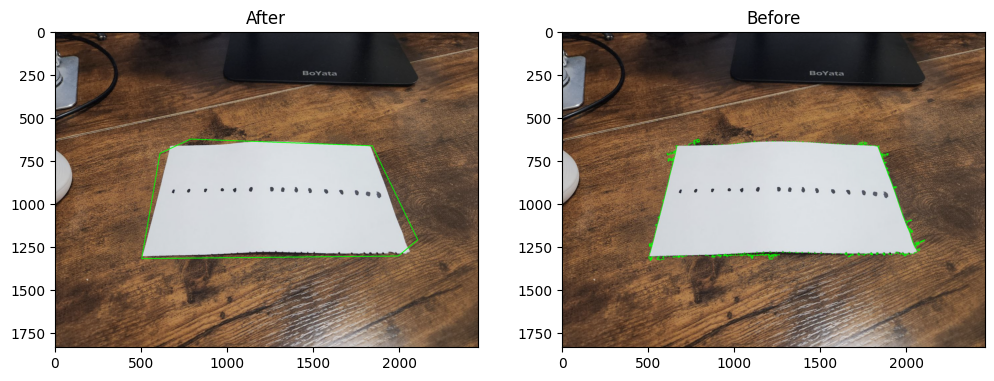

In [23]:
# We can see the contour is not smooth, we can use approxPolyDP to approximate the contour, so the line is "smoother"

# The param affect how much the contour is approximated
# you can try larger/smaller values to see the difference
# e.g. 0.1 will give you an over-approximated contour
epsilon_scale = 0.01
epsilon = epsilon_scale * cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, epsilon, True)

show_two_images(
    draw_contours(src, [approx]),
    draw_contours(src, cnt),
    is_grey=False)

print("How many vertices: ", len(approx))
print("isContourConvex: ", cv2.isContourConvex(cnt))

[[ 609.  709.]
 [1842.  665.]
 [2106. 1210.]
 [ 503. 1319.]]


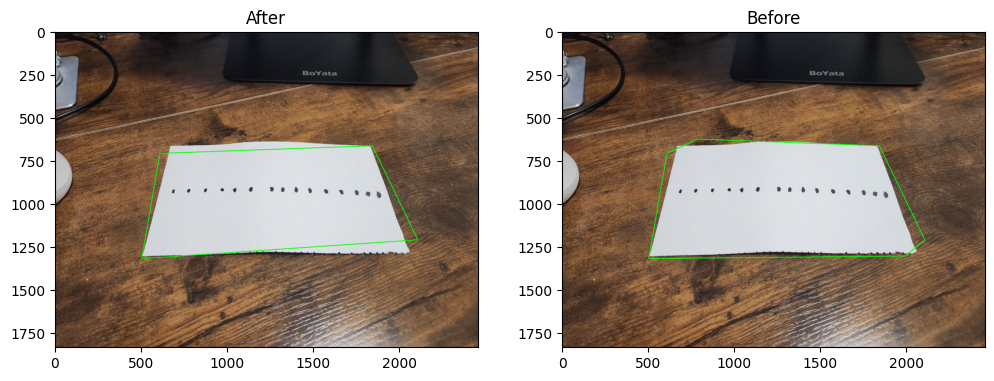

In [25]:
# Now we will find the 4 "corners" of the paper
# Note: we cannot simply take the max and min x, y values, as the paper may not be aligned with the image
# and we later will perform perspective transform, so we need to find the 4 corners in the contour
paper_contour = approx
top_l = top_r = bottom_l = bottom_r = None

for each_coord in paper_contour:
    x, y = each_coord[0]
    # For top left, x+y should be smallest
    if top_l is None or x+y < top_l[0]+top_l[1]:
        top_l = (x, y)
    # For top right, x-y should be largest
    if top_r is None or x-y > top_r[0]-top_r[1]:
        top_r = (x, y)
    # For bottom left, y-x should be largest
    if bottom_l is None or y-x > bottom_l[1]-bottom_l[0]:
        bottom_l = (x, y)
    # For bottom right, x+y should be largest
    if bottom_r is None or x+y > bottom_r[0]+bottom_r[1]:
        bottom_r = (x, y)

paper_4_pt = np.array((top_l, top_r, bottom_r, bottom_l), np.float32)
print(paper_4_pt)
# draw the contour with 4 points

show_two_images(
    draw_contours(src, [paper_4_pt.astype(int)]),
    draw_contours(src, [approx]),
    is_grey=False)

[[ 1.43763666e+00  2.49818830e-01 -1.05264228e+03]
 [ 7.35864847e-02  2.06209399e+00 -1.50683881e+03]
 [-5.36921637e-05  7.93417687e-04  1.00000000e+00]]


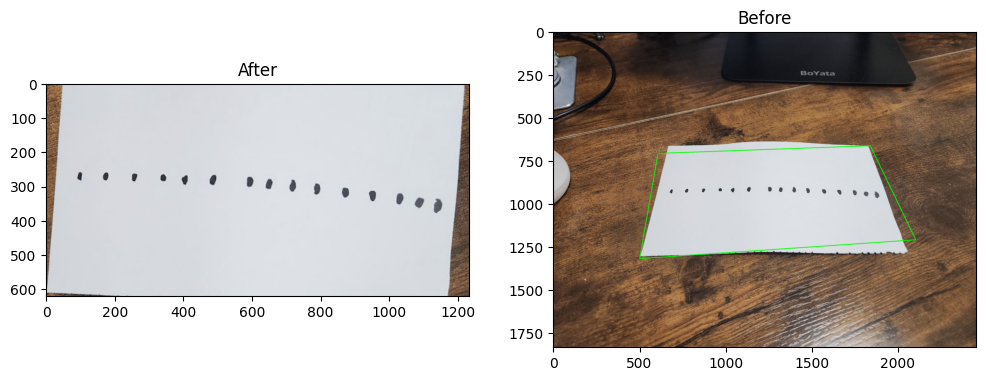

In [26]:
# Now we have the 4 points, we can perform perspective transform
# paper_4_pt: top left, top right, bottom right, bottom left

# Calculates dimensions for warped image, by calculating the distance between points
width = int(cv2.norm(paper_4_pt[0], paper_4_pt[1]))
height = int(cv2.norm(paper_4_pt[0], paper_4_pt[3]))

# Destination points
dst_points = np.array(
    [[0, 0], # Top left
        [width, 0], # Top right
        [width, height], # Bottom right
        [0, height]], # Bottom left
    dtype="float32"
)

# Calculate the perspective transform matrix
matrix = cv2.getPerspectiveTransform(paper_4_pt, dst_points)
print(matrix)
warp_img = cv2.warpPerspective(src, matrix, (width, height))
show_two_images( warp_img,
    draw_contours(src, [paper_4_pt.astype(int)]),
    is_grey=False)

-------

## Detect the black dot

We have the paper now, we can detect the black dot in a simialr way

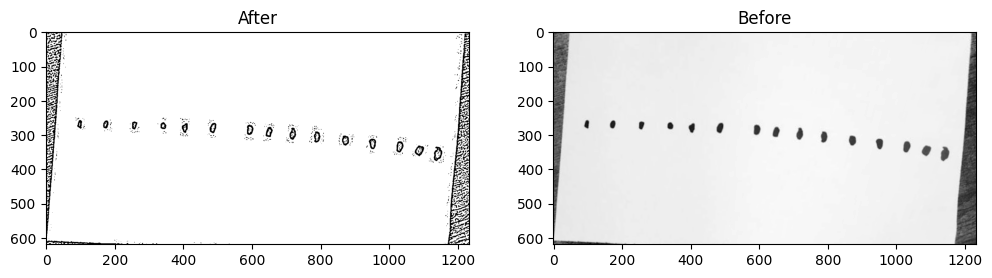

In [31]:
# warp_img is the extracted white paper

# Convert the image to grayscale
warp_img_grey = cv2.cvtColor(warp_img, cv2.COLOR_BGR2GRAY)
# Apply guassian blur
warp_img_blur = cv2.GaussianBlur(warp_img_grey, (5, 5), 0)
# Apply adaptive threshold
warp_img_thresh = cv2.adaptiveThreshold(warp_img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
show_two_images( warp_img_thresh, warp_img_blur, is_grey=True)

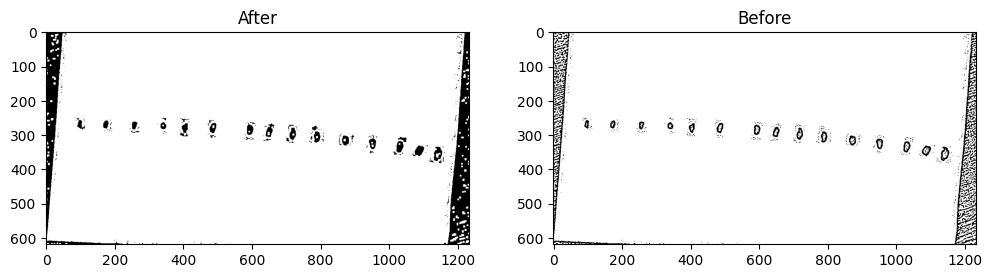

In [32]:
kernel = np.ones((5,5),np.uint8)
extraction = cv2.morphologyEx(warp_img_thresh, cv2.MORPH_OPEN, kernel)
show_two_images( extraction, warp_img_thresh, is_grey=True)

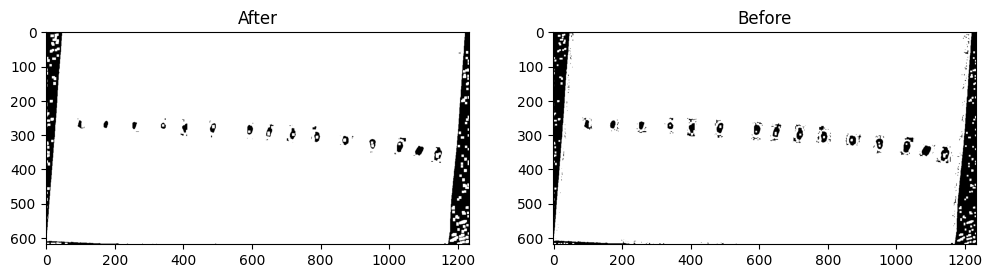

In [35]:
# Thicken cirles to make them easier to detect
kernel = np.ones((3,3),np.uint8)
thicken_circle = cv2.morphologyEx(extraction, cv2.MORPH_DILATE, kernel)
show_two_images( thicken_circle, extraction, is_grey=True)

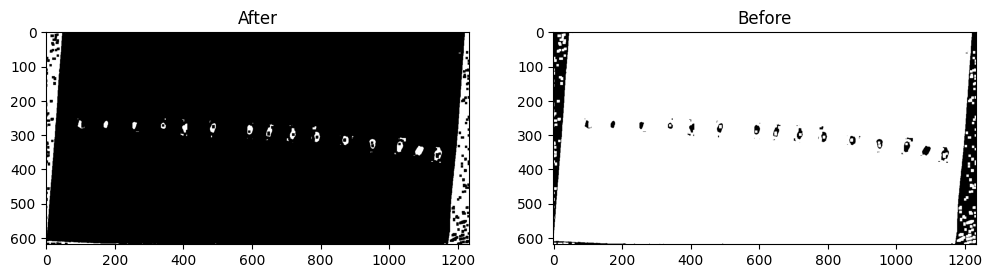

In [36]:
# flip the color for finding contours
flip_thicken_circle = cv2.bitwise_not(thicken_circle)
show_two_images(flip_thicken_circle, thicken_circle, is_grey=True)

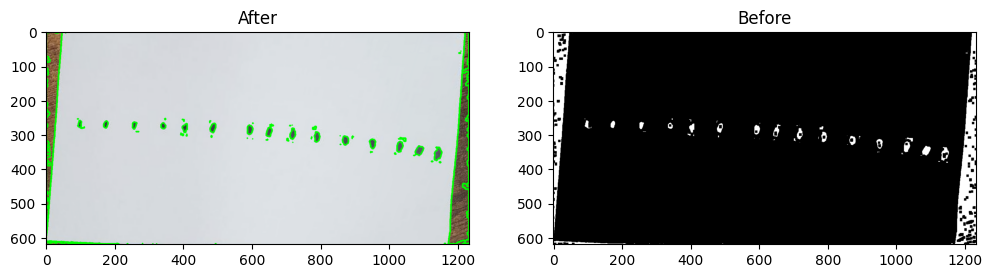

In [39]:
contours, _ = cv2.findContours(flip_thicken_circle, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

show_two_images(
    draw_contours(warp_img, contours),
    flip_thicken_circle, is_grey=False)


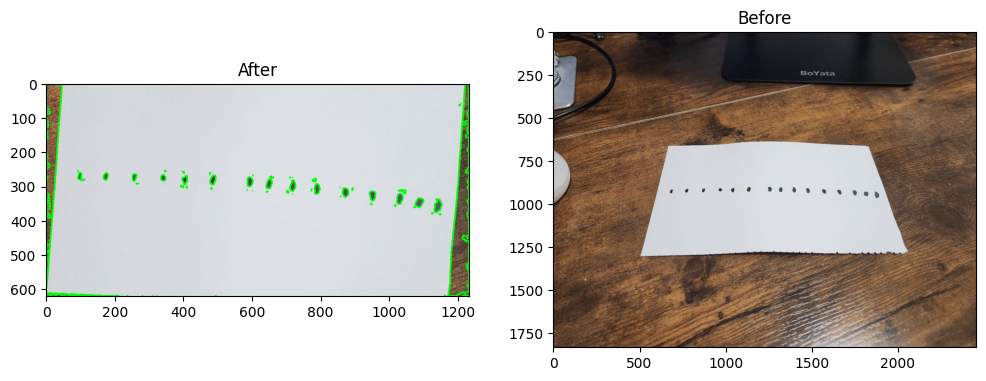

In [40]:
# Done now, we can also compare the original image with the extracted image
show_two_images(draw_contours(warp_img, contours), src, is_grey=False)